## 0. 데이터 세팅

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
titanic=pd.read_csv("../titanic/train.csv")
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 1. 이항검정

### 0. 이항검정을 위한 함수 만들기

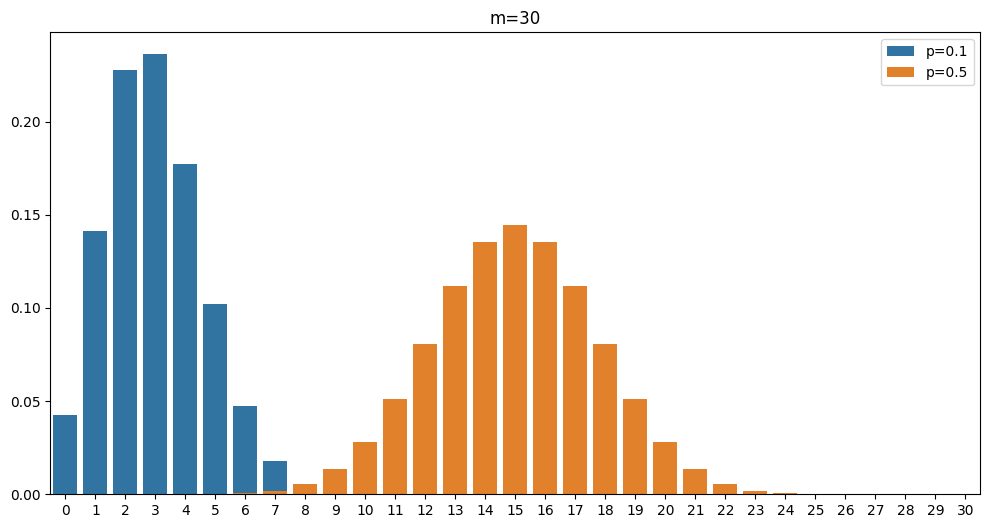

In [118]:
from numpy import linspace
from math import comb
from matplotlib import pyplot as plt
import seaborn as sb

def P(m,p):
        return {int(k):comb(m,int(k))*(p**k)*((1-p)**(m-k)) for k in linspace(0,m,m+1)}

m=30
p_s=[0.1,0.5]

plt.figure(figsize=(12,6))
plt.title("m=30")
for p in p_s:
    P_=P(m,p)
    sb.barplot(x=P_.keys(),y=P_.values(),label=f"p={p}")
plt.show()
plt.close()

### 1. 검정을 위한 모델 설정

In [63]:
from sklearn import linear_model as lin
from sklearn import model_selection as mod
from sklearn import pipeline as pip
from sklearn import compose as com
from sklearn import impute as imp
from sklearn import preprocessing as pre
import numpy as np

titanic_df=titanic.drop(columns=["PassengerId","Name","Ticket","Cabin"])
obj_col=titanic_df.dropna().select_dtypes("object").columns
num_col=titanic_df.dropna().select_dtypes(np.number).columns.difference(["Survived"])
label="Survived"

columns=titanic_df.columns.difference([label])

num_pip=pip.make_pipeline(imp.SimpleImputer(strategy="mean"),pre.StandardScaler())
obj_pip=pip.make_pipeline(imp.SimpleImputer(strategy="most_frequent"),pre.OneHotEncoder(drop="first",handle_unknown="ignore"))

total_pip=com.make_column_transformer((num_pip,num_col),(obj_pip,obj_col),remainder="passthrough")

train,test=mod.train_test_split(titanic_df,test_size=0.2,random_state=1,stratify=titanic_df[label])

model=pip.make_pipeline(total_pip,lin.LogisticRegression())

model.fit(X=train[columns],y=train[label])

print("사용한 column :",columns.values)
print("라벨 :",label)
print("사용한 모델 :",model.named_steps['logisticregression'].__class__)
model

사용한 column : ['Age' 'Embarked' 'Fare' 'Parch' 'Pclass' 'Sex' 'SibSp']
라벨 : Survived
사용한 모델 : <class 'sklearn.linear_model._logistic.LogisticRegression'>


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Fare', 'Parch', 'Pclass', 'SibSp'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Sex', 'Embarked'], dtype='object'))])),
                ('logisticregression', LogisticRegression())])

In [64]:
from sklearn import dummy as dum
from sklearn import metrics as met

processing_train=model.named_steps['columntransformer'].transform(X=train[columns])
dum_classifier=dum.DummyClassifier()
dum_classifier.fit(X=processing_train,y=train[label])

pred_y=model.predict(test[columns])
dum_y=dum_classifier.predict(test[columns])

model_acc=met.accuracy_score(y_true=test[label],y_pred=pred_y)
dummy_acc=met.accuracy_score(y_true=test[label],y_pred=dum_y)

print("테스트 오차율(모델) :",1-model_acc)
print("테스트 오차율(최빈값으로 찍기) :",1-dummy_acc)

테스트 오차율(모델) : 0.2122905027932961
테스트 오차율(최빈값으로 찍기) : 0.3854748603351955


In [226]:
from scipy import stats as st
from scipy import optimize as opt

m=len(test)
hypo_error=0.27
k=int(m*(1-model_acc))

def sum_P(p,m,k,alpha,strategy):
    temp_dc={int(k):comb(m,int(k))*(p**k)*((1-p)**(m-k)) for k in linspace(0,m,m+1)}
    if strategy>0:
        return sum([temp_dc[key] for key in temp_dc if key>k])-alpha
    else:
        return sum([temp_dc[key] for key in temp_dc if key<k])-alpha

optmize_P_less=partial(sum_P,m=m,k=k,alpha=0.05,strategy=1)
 
bar_epsilon_result=opt.root_scalar(optmize_P_less,bracket=[0,1])

if bar_epsilon_result.converged:
    bar_epsilon=bar_epsilon_result.root

print("임계값 : ",bar_epsilon)

임계값 :  0.1681356027379127


Text(0.5, 1.0, 'P=0.27')

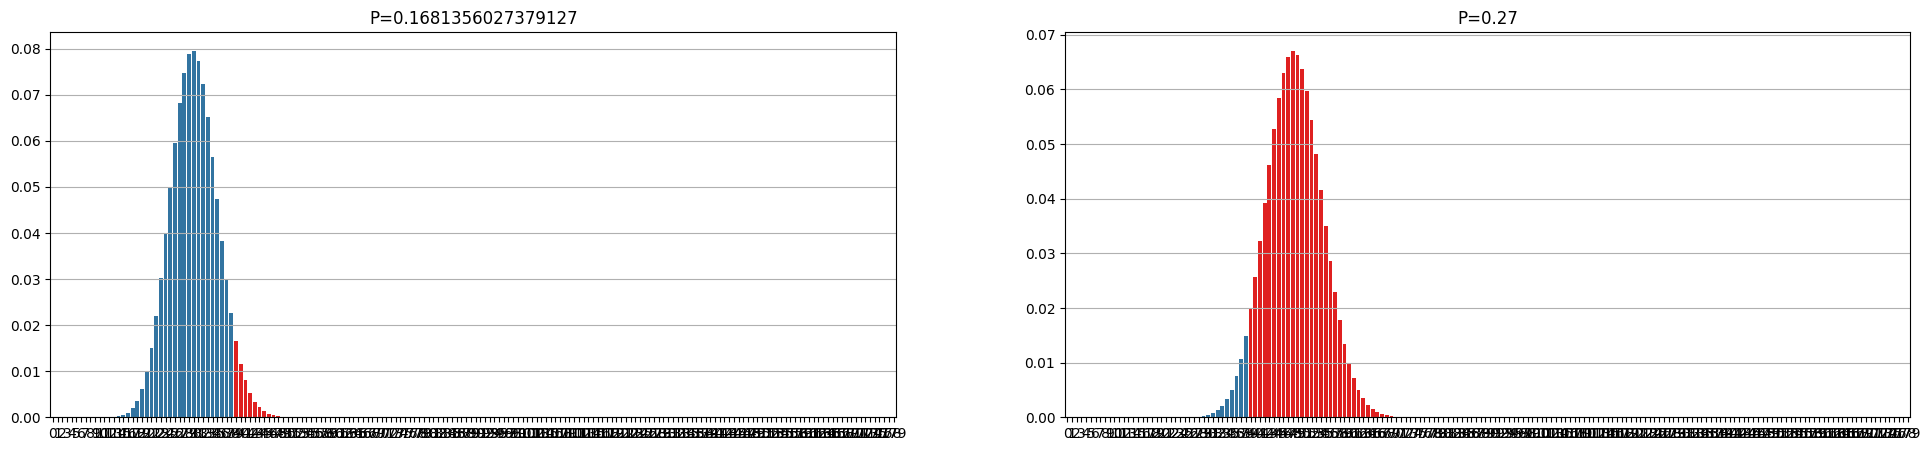

In [241]:
from matplotlib import pyplot
import seaborn as sb

bar_epsilon_dist=P(m,p=bar_epsilon)
upper_={key:value for key,value in bar_epsilon_dist.items() if key>k}
_,(a1,a2)=plt.subplots(1,2,figsize=(24,5))
sb.barplot(x=bar_epsilon_dist.keys(),y=bar_epsilon_dist.values(),ax=a1)
sb.barplot(x=upper_.keys(),y=upper_.values(),color="red",ax=a1)
a1.grid(axis="y")

hypo_dist=P(m,p=hypo_error)
upper_2={key:value for key,value in hypo_dist.items() if key>k}

sb.barplot(x=hypo_dist.keys(),y=hypo_dist.values(),ax=a2)
sb.barplot(x=upper_2.keys(),y=upper_2.values(),color="red",ax=a2)
a2.grid(axis="y")

a1.set_title(f"P={bar_epsilon}")
a2.set_title(f"P={hypo_error}")

In [243]:
1-model_acc

0.2122905027932961

### 부가설명

In [165]:
from functools import partial
from math import comb
from numpy import linspace
from scipy import stats as st
from scipy import optimize as opt

m=len(test)
hypo_error=0.22
test_error=1-model_acc

def sum_P(p,m,k,alpha,strategy):
    temp_dc={int(k):comb(m,int(k))*(p**k)*((1-p)**(m-k)) for k in linspace(0,m,m+1)}
    if strategy>0:
        return sum([temp_dc[key] for key in temp_dc if key>k])-alpha
    else:
        return sum([temp_dc[key] for key in temp_dc if key<k])-alpha

optmize_P_greater=partial(sum_P,m=m,k=hypo_error*m,alpha=0.1,strategy=1)
optmize_P_less=partial(sum_P,m=m,k=hypo_error*m,alpha=0.1,strategy=-1)

In [166]:
max_epsilon=opt.root_scalar(optmize_P_greater,bracket=[0,1]).root

In [167]:
max_epsilon

0.18327064144725347

Text(0.5, 1.0, 'P=0.55')

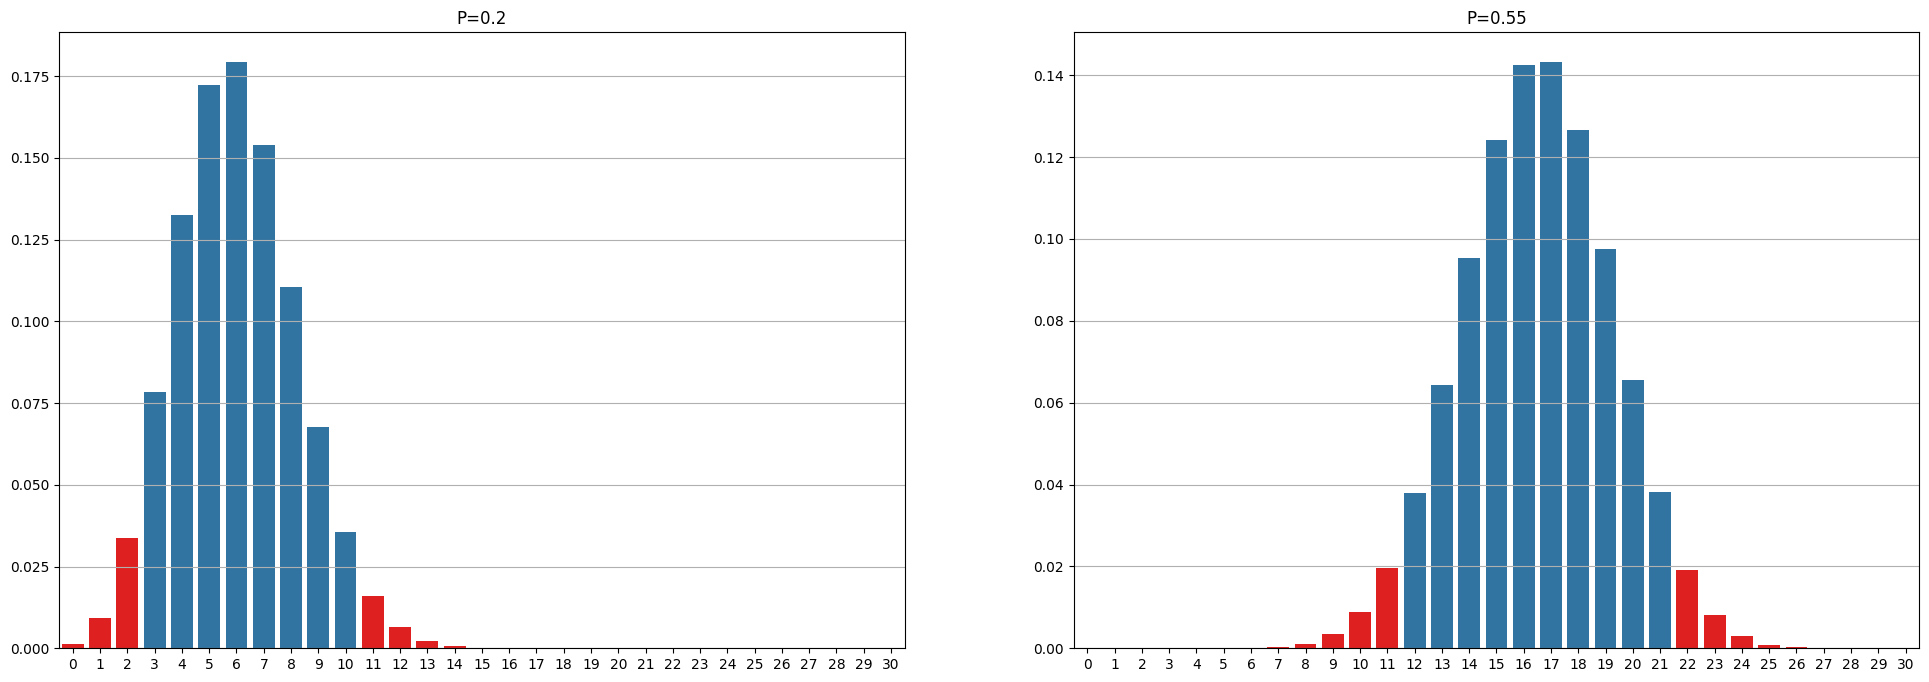

In [182]:
norm1=P(30,p=0.20)
min_1=list(norm1.items())
min_1.sort(key=lambda x:x[1])

area1={}
for x,y in min_1:
    if sum(area1.values())>0.05:
        break
    area1.update({x:y})

norm2=P(30,p=0.55)
min_2=list(norm2.items())
min_2.sort(key=lambda x:x[1])

area2={}
for x,y in min_2:
    if sum(area2.values())>0.05:
        break
    area2.update({x:y})

f,(a1,a2)=plt.subplots(1,2,figsize=(24,8))
sb.barplot(x=norm1.keys(),y=norm1.values(),ax=a1)
sb.barplot(x=area1.keys(),y=area1.values(),color="red",ax=a1)
sb.barplot(x=norm2.keys(),y=norm2.values(),ax=a2)
sb.barplot(x=area2.keys(),y=area2.values(),color="red",ax=a2)
a1.grid(axis="y")
a2.grid(axis="y")
a1.set_title("P=0.2")
a2.set_title("P=0.55")

In [225]:
st.binomtest(k=11,n=30,p=0.56)

BinomTestResult(k=11, n=30, alternative='two-sided', statistic=0.36666666666666664, pvalue=0.04189955612694294)

Text(0.5, 1.0, 'P=0.45')

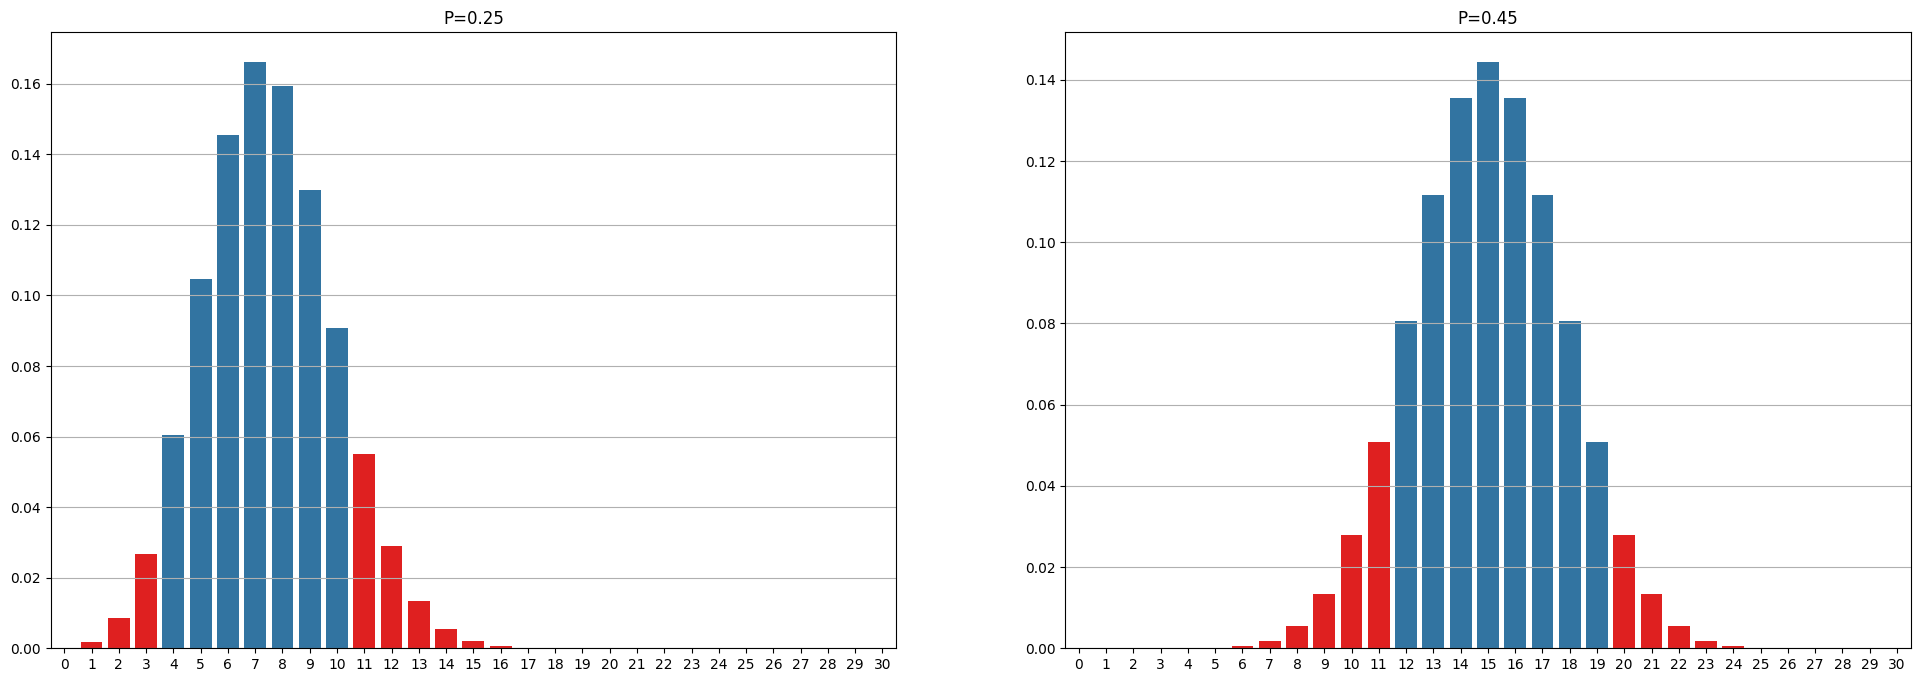

In [183]:
norm1=P(30,p=0.25)
min_1=list(norm1.items())
min_1.sort(key=lambda x:x[1])

area1={}
for x,y in min_1:
    if sum(area1.values())>0.1:
        break
    area1.update({x:y})

norm2=P(30,p=0.5)
min_2=list(norm2.items())
min_2.sort(key=lambda x:x[1])

area2={}
for x,y in min_2:
    if sum(area2.values())>0.1:
        break
    area2.update({x:y})

_,(a1,a2)=plt.subplots(1,2,figsize=(24,8))
sb.barplot(x=norm1.keys(),y=norm1.values(),ax=a1)
sb.barplot(x=area1.keys(),y=area1.values(),color="red",ax=a1)
sb.barplot(x=norm2.keys(),y=norm2.values(),ax=a2)
sb.barplot(x=area2.keys(),y=area2.values(),color="red",ax=a2)
a1.grid(axis="y")
a2.grid(axis="y")
a1.set_title("P=0.25")
a2.set_title("P=0.45")

In [ ]:
norm1=P(30,p=0.30)
min_1=list(norm1.items())
min_1.sort(key=lambda x:x[1])

area1={}
for x,y in min_1:
    if sum(area1.values())>0.05:
        break
    area1.update({x:y})

norm2=P(30,p=0.55)
min_2=list(norm2.items())
min_2.sort(key=lambda x:x[1])

area2={}
for x,y in min_2:
    if sum(area2.values())>0.05:
        break
    area2.update({x:y})

f,(a1,a2)=plt.subplots(1,2,figsize=(24,8))
sb.barplot(x=norm1.keys(),y=norm1.values(),ax=a1)
sb.barplot(x=area1.keys(),y=area1.values(),color="red",ax=a1)
sb.barplot(x=norm2.keys(),y=norm2.values(),ax=a2)
sb.barplot(x=area2.keys(),y=area2.values(),color="red",ax=a2)
a1.grid(axis="y")
a2.grid(axis="y")
a1.set_title("P=0.2")
a2.set_title("P=0.55")